<a href="https://colab.research.google.com/github/soumyapachal-SP/Intrusion-Detection-System/blob/main/NSL_KDD_IDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mounting to Drive for fetching the datasets**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading and extracting the Zip files**

In [ ]:
import zipfile
import os

# Define file paths
file_paths = {
    "train_full": "/content/drive/MyDrive/NSL-KDD-dataset/KDDTrain+.txt.zip",
    "train_20": "/content/drive/MyDrive/NSL-KDD-dataset/KDDTrain+_20Percent.txt.zip",
    "test_full": "/content/drive/MyDrive/NSL-KDD-dataset/KDDTest+.txt.zip",
    "test_21": "/content/drive/MyDrive/NSL-KDD-dataset/KDDTest-21.txt.zip",
}

# Extract files
extracted_files = {}
for key, path in file_paths.items():
    with zipfile.ZipFile(path, 'r') as zip_ref:
        extracted_dir = "/mnt/data/"
        zip_ref.extractall(extracted_dir)
        extracted_files[key] = [
            os.path.join(extracted_dir, name) for name in zip_ref.namelist()
        ]

# List extracted files
extracted_files


{'train_full': ['/mnt/data/KDDTrain+.txt'],
 'train_20': ['/mnt/data/KDDTrain+_20Percent.txt'],
 'test_full': ['/mnt/data/KDDTest+.txt'],
 'test_21': ['/mnt/data/KDDTest-21.txt']}

**Defining the column names**

In [ ]:
import pandas as pd

# Define column names based on NSL-KDD dataset description
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment",
    "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted",
    "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label", "difficulty"
]

# Load datasets
train_df = pd.read_csv(extracted_files['train_full'][0], names=columns)
test_df = pd.read_csv(extracted_files['test_full'][0], names=columns)

# Display basic info
train_df.info(), test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

(None, None)

**Check class distribution in the training and test datasets**

In [ ]:
# Check class distribution in the training and test datasets
train_class_distribution = train_df["label"].value_counts(normalize=True) * 100
test_class_distribution = test_df["label"].value_counts(normalize=True) * 100

train_class_distribution, test_class_distribution


(label
 normal             53.458281
 neptune            32.716534
 satan               2.883951
 ipsweep             2.856961
 portsweep           2.326689
 smurf               2.100450
 nmap                1.185175
 back                0.758893
 teardrop            0.708088
 warezclient         0.706501
 pod                 0.159558
 guess_passwd        0.042073
 buffer_overflow     0.023815
 warezmaster         0.015876
 land                0.014289
 imap                0.008732
 rootkit             0.007938
 loadmodule          0.007144
 ftp_write           0.006351
 multihop            0.005557
 phf                 0.003175
 perl                0.002381
 spy                 0.001588
 Name: proportion, dtype: float64,
 label
 normal             43.075763
 neptune            20.657381
 guess_passwd        5.460433
 mscan               4.418027
 warezmaster         4.187367
 apache2             3.269163
 satan               3.260291
 processtable        3.038502
 smurf               

In [ ]:
!pip install optuna

**Encoding the categorical features using OnehotEncoder, Handle class imbalance using SMOTE-Tomek and training the models**

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.combine import SMOTETomek
import optuna
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Encode categorical features using OneHotEncoder
categorical_features = ["protocol_type", "service", "flag"]
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_train = ohe.fit_transform(train_df[categorical_features])
encoded_test = ohe.transform(test_df[categorical_features])

ohe_df_train = pd.DataFrame(encoded_train, columns=ohe.get_feature_names_out())
ohe_df_test = pd.DataFrame(encoded_test, columns=ohe.get_feature_names_out())


train_df = train_df.drop(columns=categorical_features).reset_index(drop=True)
test_df = test_df.drop(columns=categorical_features).reset_index(drop=True)

train_df = pd.concat([train_df, ohe_df_train], axis=1)
test_df = pd.concat([test_df, ohe_df_test], axis=1)

# Convert labels to binary (0: normal, 1: attack)
train_df["label"] = train_df["label"].apply(lambda x: 0 if x == "normal" else 1)
test_df["label"] = test_df["label"].apply(lambda x: 0 if x == "normal" else 1)

# Scale numerical features
scaler = StandardScaler()
numeric_features = train_df.columns.difference(["label"])
train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])
test_df[numeric_features] = scaler.transform(test_df[numeric_features])

# Split features and target
X_train, y_train = train_df.drop(columns=["label"]), train_df["label"]
X_test, y_test = test_df.drop(columns=["label"]), test_df["label"]

# Handle class imbalance using SMOTE-Tomek
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# Feature Selection using Permutation Importance
rf_feature_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feature_selector.fit(X_train_resampled, y_train_resampled)
perm_importance = permutation_importance(rf_feature_selector, X_test, y_test, scoring='accuracy')
important_features = X_train.columns[np.where(perm_importance.importances_mean > 0.001)]
X_train_resampled = X_train_resampled[important_features]
X_test = X_test[important_features]

# Define objective function for Optuna tuning
def objective(trial):
    model_type = trial.suggest_categorical("model", ["rf", "xgb", "lgb"])
    if model_type == "rf":
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators", 200, 500),
            max_depth=trial.suggest_int("max_depth", 15, 40),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
            random_state=42
        )
    elif model_type == "xgb":
        model = XGBClassifier(
            learning_rate=trial.suggest_loguniform("learning_rate", 0.01, 0.2),
            max_depth=trial.suggest_int("max_depth", 5, 12),
            n_estimators=trial.suggest_int("n_estimators", 200, 500),
            eval_metric="logloss",
            random_state=42
        )
    else:
        model = LGBMClassifier(
            num_leaves=trial.suggest_int("num_leaves", 30, 60),
            min_child_samples=trial.suggest_int("min_child_samples", 10, 40),
            n_estimators=trial.suggest_int("n_estimators", 200, 500),
            random_state=42
        )
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Train best model
best_params = study.best_params
if best_params["model"] == "rf":
    final_model = RandomForestClassifier(**{k: v for k, v in best_params.items() if k != "model"}, random_state=42)
elif best_params["model"] == "xgb":
    final_model = XGBClassifier(**{k: v for k, v in best_params.items() if k != "model"}, eval_metric="logloss", random_state=42)
else:
    final_model = LGBMClassifier(**{k: v for k, v in best_params.items() if k != "model"}, random_state=42)

final_model.fit(X_train_resampled, y_train_resampled)
y_pred_final = final_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Model Accuracy: {final_accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred_final))

[I 2025-03-02 10:47:32,416] A new study created in memory with name: no-name-12125c06-a756-422c-b54b-a158e1575be6
<ipython-input-6-2995614f59b4>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 0.01, 0.2),
[I 2025-03-02 10:47:42,963] Trial 0 finished with value: 0.8721611071682044 and parameters: {'model': 'xgb', 'learning_rate': 0.06853945730540183, 'max_depth': 9, 'n_estimators': 438}. Best is trial 0 with value: 0.8721611071682044.


[LightGBM] [Info] Number of positive: 67330, number of negative: 67330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2545
[LightGBM] [Info] Number of data points in the train set: 134660, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-03-02 10:47:50,166] Trial 1 finished with value: 0.8695883605393896 and parameters: {'model': 'lgb', 'num_leaves': 59, 'min_child_samples': 17, 'n_estimators': 272}. Best is trial 0 with value: 0.8721611071682044.
[I 2025-03-02 10:48:24,712] Trial 2 finished with value: 0.852111426543648 and parameters: {'model': 'rf', 'n_estimators': 273, 'max_depth': 38, 'min_samples_split': 2}. Best is trial 0 with value: 0.8721611071682044.
[I 2025-03-02 10:48:54,765] Trial 3 finished with value: 0.8451029098651526 and parameters: {'model': 'rf', 'n_estimators': 244, 'max_depth': 36, 'min_samples_split': 9}. Best is trial 0 with value: 0.8721611071682044.


[LightGBM] [Info] Number of positive: 67330, number of negative: 67330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2545
[LightGBM] [Info] Number of data points in the train set: 134660, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-03-02 10:49:02,610] Trial 4 finished with value: 0.8656405251951739 and parameters: {'model': 'lgb', 'num_leaves': 60, 'min_child_samples': 31, 'n_estimators': 258}. Best is trial 0 with value: 0.8721611071682044.
<ipython-input-6-2995614f59b4>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 0.01, 0.2),
[I 2025-03-02 10:49:09,362] Trial 5 finished with value: 0.8696327182398864 and parameters: {'model': 'xgb', 'learning_rate': 0.01187692080878125, 'max_depth': 11, 'n_estimators': 291}. Best is trial 0 with value: 0.8721611071682044.


[LightGBM] [Info] Number of positive: 67330, number of negative: 67330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2545
[LightGBM] [Info] Number of data points in the train set: 134660, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-03-02 10:49:17,768] Trial 6 finished with value: 0.8663946061036196 and parameters: {'model': 'lgb', 'num_leaves': 43, 'min_child_samples': 31, 'n_estimators': 301}. Best is trial 0 with value: 0.8721611071682044.
[I 2025-03-02 10:50:12,631] Trial 7 finished with value: 0.8535308729595458 and parameters: {'model': 'rf', 'n_estimators': 458, 'max_depth': 26, 'min_samples_split': 2}. Best is trial 0 with value: 0.8721611071682044.
<ipython-input-6-2995614f59b4>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 0.01, 0.2),
[I 2025-03-02 10:50:19,614] Trial 8 finished with value: 0.8640436479772888 and parameters: {'model': 'xgb', 'learning_rate': 0.01506707766197048, 'max_depth': 8, 'n_estimators': 374}. Best is trial 0 with value: 0.8721611071682044.
<ipython-input-6

[LightGBM] [Info] Number of positive: 67330, number of negative: 67330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2545
[LightGBM] [Info] Number of data points in the train set: 134660, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-03-02 10:51:49,711] Trial 18 finished with value: 0.8613378282469837 and parameters: {'model': 'lgb', 'num_leaves': 33, 'min_child_samples': 40, 'n_estimators': 453}. Best is trial 0 with value: 0.8721611071682044.
[I 2025-03-02 10:52:44,599] Trial 19 finished with value: 0.8561479772888574 and parameters: {'model': 'rf', 'n_estimators': 462, 'max_depth': 18, 'min_samples_split': 10}. Best is trial 0 with value: 0.8721611071682044.
<ipython-input-6-2995614f59b4>:66: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 0.01, 0.2),
[I 2025-03-02 10:52:51,720] Trial 20 finished with value: 0.8792583392476934 and parameters: {'model': 'xgb', 'learning_rate': 0.03594988432081616, 'max_depth': 9, 'n_estimators': 396}. Best is trial 20 with value: 0.8792583392476934.
<ipython-in

[LightGBM] [Info] Number of positive: 67330, number of negative: 67330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2545
[LightGBM] [Info] Number of data points in the train set: 134660, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2025-03-02 10:54:04,851] Trial 28 finished with value: 0.872693399574166 and parameters: {'model': 'lgb', 'num_leaves': 31, 'min_child_samples': 11, 'n_estimators': 430}. Best is trial 27 with value: 0.8817423704755145.
[I 2025-03-02 10:54:56,659] Trial 29 finished with value: 0.8512242725337118 and parameters: {'model': 'rf', 'n_estimators': 445, 'max_depth': 17, 'min_samples_split': 6}. Best is trial 27 with value: 0.8817423704755145.


Final Model Accuracy: 88.17%
              precision    recall  f1-score   support

           0       0.80      0.97      0.88      9711
           1       0.97      0.81      0.89     12833

    accuracy                           0.88     22544
   macro avg       0.89      0.89      0.88     22544
weighted avg       0.90      0.88      0.88     22544



**Accuracies of the three ensemble models**

In [ ]:
rf_model = RandomForestClassifier(n_estimators=300, max_depth=30, min_samples_split=5, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")

xgb_model = XGBClassifier(learning_rate=0.1, max_depth=8, n_estimators=300, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {xgb_accuracy * 100:.2f}%")

lgb_model = LGBMClassifier(num_leaves=40, min_child_samples=15, n_estimators=300, random_state=42)
lgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_lgb = lgb_model.predict(X_test)
lgb_accuracy = accuracy_score(y_test, y_pred_lgb)
print(f"LightGBM Accuracy: {lgb_accuracy * 100:.2f}%")


Random Forest Accuracy: 85.06%
XGBoost Accuracy: 87.76%
[LightGBM] [Info] Number of positive: 67330, number of negative: 67330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2545
[LightGBM] [Info] Number of data points in the train set: 134660, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 86.54%


In [ ]:
# prompt: give the classification report of the above models
from sklearn.metrics import classification_report # Import classification_report

print(classification_report(y_test, y_pred_final))
print(classification_report(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_lgb))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88      9711
           1       0.97      0.81      0.89     12833

    accuracy                           0.88     22544
   macro avg       0.89      0.89      0.88     22544
weighted avg       0.90      0.88      0.88     22544

              precision    recall  f1-score   support

           0       0.75      0.97      0.85      9711
           1       0.97      0.76      0.85     12833

    accuracy                           0.85     22544
   macro avg       0.86      0.87      0.85     22544
weighted avg       0.88      0.85      0.85     22544

              precision    recall  f1-score   support

           0       0.79      0.97      0.87      9711
           1       0.97      0.81      0.88     12833

    accuracy                           0.88     22544
   macro avg       0.88      0.89      0.88     22544
weighted avg       0.90      0.88      0.88     22544

              preci

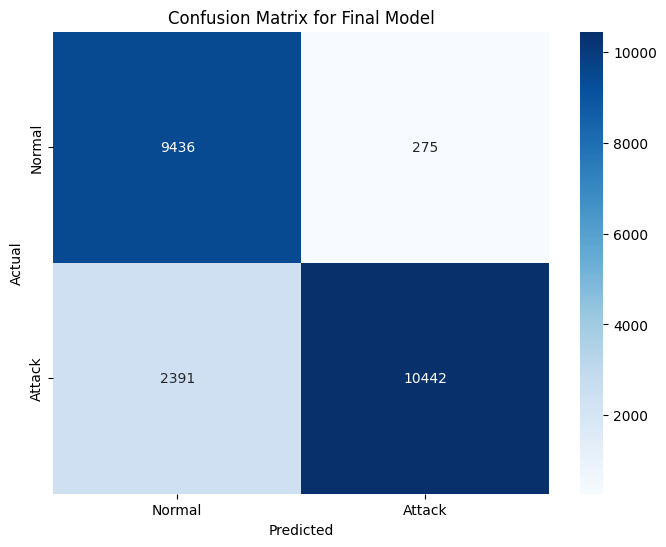

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_final are already defined from your previous code
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Final Model")
plt.show()


In [ ]:
import zipfile
import os

# Define file paths
file_paths = {
    "train_full": "/content/drive/MyDrive/NSL-KDD-dataset/KDDTrain+.txt.zip",
    "train_20": "/content/drive/MyDrive/NSL-KDD-dataset/KDDTrain+_20Percent.txt.zip",
    "test_full": "/content/drive/MyDrive/NSL-KDD-dataset/KDDTest+.txt.zip",
    "test_21": "/content/drive/MyDrive/NSL-KDD-dataset/KDDTest-21.txt.zip",
}

# Extract files
extracted_files = {}
for key, path in file_paths.items():
    with zipfile.ZipFile(path, 'r') as zip_ref:
        extracted_dir = "/mnt/data/"
        zip_ref.extractall(extracted_dir)
        extracted_files[key] = [
            os.path.join(extracted_dir, name) for name in zip_ref.namelist()
        ]

# List extracted files
extracted_files
import pandas as pd

# Define column names based on NSL-KDD dataset description
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment",
    "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted",
    "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label", "difficulty"
]

# Load datasets
train_df = pd.read_csv(extracted_files['train_full'][0], names=columns)
test_df = pd.read_csv(extracted_files['test_full'][0], names=columns)

# Display basic info
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

(None, None)

**Encoding the categorical features using OnehotEncoder, Handle class imbalance using SMOTE-Tomek, with an adjusted strategies and training the models**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from imblearn.combine import SMOTETomek
import optuna
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Encode categorical features using OneHotEncoder
categorical_features = ["protocol_type", "service", "flag"]
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_train = ohe.fit_transform(train_df[categorical_features])
encoded_test = ohe.transform(test_df[categorical_features])

ohe_df_train = pd.DataFrame(encoded_train, columns=ohe.get_feature_names_out())
ohe_df_test = pd.DataFrame(encoded_test, columns=ohe.get_feature_names_out())

train_df = train_df.drop(columns=categorical_features).reset_index(drop=True)
test_df = test_df.drop(columns=categorical_features).reset_index(drop=True)

train_df = pd.concat([train_df, ohe_df_train], axis=1)
test_df = pd.concat([test_df, ohe_df_test], axis=1)

# Convert labels to binary (0: normal, 1: attack)
train_df["label"] = train_df["label"].apply(lambda x: 0 if x == "normal" else 1)
test_df["label"] = test_df["label"].apply(lambda x: 0 if x == "normal" else 1)

# Scale numerical features
scaler = StandardScaler()
numeric_features = train_df.columns.difference(["label"])
train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])
test_df[numeric_features] = scaler.transform(test_df[numeric_features])

# Split features and target
X_train, y_train = train_df.drop(columns=["label"]), train_df["label"]
X_test, y_test = test_df.drop(columns=["label"]), test_df["label"]

# Reduce oversampling ratio to balance recall and accuracy
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Check class distribution
class_counts = y_train.value_counts()
normal_count, attack_count = class_counts[0], class_counts[1]
ratio = attack_count / normal_count

# If attack samples dominate, undersample normal class
if ratio > 1:
    rus = RandomUnderSampler(sampling_strategy=0.9, random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)

# Apply SMOTETomek with an adjusted strategy
smote_tomek = SMOTETomek(sampling_strategy=0.9, random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# Feature Selection using Permutation Importance
rf_feature_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_feature_selector.fit(X_train_resampled, y_train_resampled)
perm_importance = permutation_importance(rf_feature_selector, X_test, y_test, scoring='accuracy')
important_features = X_train.columns[np.where(perm_importance.importances_mean > 0.002)]  # Keep only more important features
X_train_resampled = X_train_resampled[important_features]
X_test = X_test[important_features]

# Define objective function for Optuna tuning
def objective(trial):
    model_type = trial.suggest_categorical("model", ["rf", "xgb", "lgb"])
    if model_type == "rf":
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators", 200, 500),
            max_depth=trial.suggest_int("max_depth", 15, 40),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
            class_weight={0: 1, 1: 0.8},  # Slightly favor normal traffic
            random_state=42
        )
    elif model_type == "xgb":
        model = XGBClassifier(
            learning_rate=trial.suggest_loguniform("learning_rate", 0.01, 0.2),
            max_depth=trial.suggest_int("max_depth", 5, 12),
            n_estimators=trial.suggest_int("n_estimators", 200, 500),
            eval_metric="logloss",
            scale_pos_weight=0.8,  # Reduce the impact of attack class
            random_state=42
        )
    else:
        model = LGBMClassifier(
            num_leaves=trial.suggest_int("num_leaves", 30, 60),
            min_child_samples=trial.suggest_int("min_child_samples", 10, 40),
            n_estimators=trial.suggest_int("n_estimators", 200, 500),
            class_weight={0: 1, 1: 0.8},
            random_state=42
        )
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Train best model
best_params = study.best_params
if best_params["model"] == "rf":
    final_model = RandomForestClassifier(
        **{k: v for k, v in best_params.items() if k != "model"}, class_weight={0: 1, 1: 0.8}, random_state=42
    )
elif best_params["model"] == "xgb":
    final_model = XGBClassifier(
        **{k: v for k, v in best_params.items() if k != "model"}, eval_metric="logloss", scale_pos_weight=0.8, random_state=42
    )
else:
    final_model = LGBMClassifier(
        **{k: v for k, v in best_params.items() if k != "model"}, class_weight={0: 1, 1: 0.8}, random_state=42
    )

final_model.fit(X_train_resampled, y_train_resampled)
y_pred_final = (final_model.predict_proba(X_test)[:, 1] > 0.55).astype(int)  # Adjust threshold for better accuracy

final_accuracy = accuracy_score(y_test, y_pred_final)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_final, average="binary")

print(f"Final Model Accuracy: {final_accuracy * 100:.2f}%")
print(f"Final Model Precision: {precision:.2f}")
print(f"Final Model Recall: {recall:.2f}")
print(f"Final Model F1-score: {f1:.2f}")
print(classification_report(y_test, y_pred_final))


[I 2025-03-02 11:52:05,380] A new study created in memory with name: no-name-58b9e98e-4456-4ec1-9d30-4a13cd594908


[LightGBM] [Info] Number of positive: 60595, number of negative: 67330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2486
[LightGBM] [Info] Number of data points in the train set: 127925, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.418597 -> initscore=-0.328537
[LightGBM] [Info] Start training from score -0.328537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-02 11:52:16,396] Trial 0 finished with value: 0.8629790631653655 and parameters: {'model': 'lgb', 'num_leaves': 46, 'min_child_samples': 33, 'n_estimators': 478}. Best is trial 0 with value: 0.8629790631653655.


[LightGBM] [Info] Number of positive: 60595, number of negative: 67330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2486
[LightGBM] [Info] Number of data points in the train set: 127925, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.418597 -> initscore=-0.328537
[LightGBM] [Info] Start training from score -0.328537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-02 11:52:23,257] Trial 1 finished with value: 0.8628459900638751 and parameters: {'model': 'lgb', 'num_leaves': 45, 'min_child_samples': 23, 'n_estimators': 321}. Best is trial 0 with value: 0.8629790631653655.
[I 2025-03-02 11:53:16,684] Trial 2 finished with value: 0.8604063165365508 and parameters: {'model': 'rf', 'n_estimators': 397, 'max_depth': 27, 'min_samples_split': 3}. Best is trial 0 with value: 0.8629790631653655.


[LightGBM] [Info] Number of positive: 60595, number of negative: 67330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2486
[LightGBM] [Info] Number of data points in the train set: 127925, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.418597 -> initscore=-0.328537
[LightGBM] [Info] Start training from score -0.328537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-02 11:53:26,597] Trial 3 finished with value: 0.8616039744499645 and parameters: {'model': 'lgb', 'num_leaves': 43, 'min_child_samples': 10, 'n_estimators': 416}. Best is trial 0 with value: 0.8629790631653655.
[I 2025-03-02 11:54:13,676] Trial 4 finished with value: 0.8642210787792761 and parameters: {'model': 'rf', 'n_estimators': 358, 'max_depth': 36, 'min_samples_split': 6}. Best is trial 4 with value: 0.8642210787792761.
[I 2025-03-02 11:55:11,762] Trial 5 finished with value: 0.8619144783534421 and parameters: {'model': 'rf', 'n_estimators': 427, 'max_depth': 28, 'min_samples_split': 2}. Best is trial 4 with value: 0.8642210787792761.
<ipython-input-29-e49c9c5b2e34>:81: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 0.01, 0.2),
[I 2025-03-02 11:55:19,624] T

[LightGBM] [Info] Number of positive: 60595, number of negative: 67330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2486
[LightGBM] [Info] Number of data points in the train set: 127925, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.418597 -> initscore=-0.328537
[LightGBM] [Info] Start training from score -0.328537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-02 11:55:37,840] Trial 9 finished with value: 0.8554826117814053 and parameters: {'model': 'lgb', 'num_leaves': 60, 'min_child_samples': 29, 'n_estimators': 225}. Best is trial 6 with value: 0.8693222143364088.
<ipython-input-29-e49c9c5b2e34>:81: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate=trial.suggest_loguniform("learning_rate", 0.01, 0.2),
[I 2025-03-02 11:55:45,023] Trial 10 finished with value: 0.8757984386089425 and parameters: {'model': 'xgb', 'learning_rate': 0.010076865764085442, 'max_depth': 5, 'n_estimators': 277}. Best is trial 10 with value: 0.8757984386089425.
<ipython-input-29-e49c9c5b2e34>:81: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True)

[LightGBM] [Info] Number of positive: 60595, number of negative: 67330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2486
[LightGBM] [Info] Number of data points in the train set: 127925, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.418597 -> initscore=-0.328537
[LightGBM] [Info] Start training from score -0.328537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[I 2025-03-02 11:58:29,693] Trial 29 finished with value: 0.8652413058907026 and parameters: {'model': 'lgb', 'num_leaves': 31, 'min_child_samples': 40, 'n_estimators': 464}. Best is trial 17 with value: 0.8813431511710433.


Final Model Accuracy: 87.74%
Final Model Precision: 0.98
Final Model Recall: 0.80
Final Model F1-score: 0.88
              precision    recall  f1-score   support

           0       0.79      0.98      0.87      9711
           1       0.98      0.80      0.88     12833

    accuracy                           0.88     22544
   macro avg       0.88      0.89      0.88     22544
weighted avg       0.90      0.88      0.88     22544



In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Train and evaluate three models separately
models = {
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=30, min_samples_split=5, class_weight={0: 1, 1: 0.8}, random_state=42),
    "XGBoost": XGBClassifier(learning_rate=0.05, max_depth=8, n_estimators=300, eval_metric="logloss", scale_pos_weight=0.8, random_state=42),
    "LightGBM": LGBMClassifier(num_leaves=40, min_child_samples=20, n_estimators=300, class_weight={0: 1, 1: 0.8}, random_state=42)
}

for name, model in models.items():
    print(f"\n{'='*30}\nTraining {name} Model\n{'='*30}")

    # Train the model
    model.fit(X_train_resampled, y_train_resampled)

    # Predict on test data
    y_pred = (model.predict_proba(X_test)[:, 1] > 0.55).astype(int)  # Adjust threshold for better accuracy

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Model Accuracy: {accuracy * 100:.2f}%\n")

    # Print classification report
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred))



Training Random Forest Model
Random Forest Model Accuracy: 83.55%

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.73      0.97      0.84      9711
           1       0.97      0.73      0.83     12833

    accuracy                           0.84     22544
   macro avg       0.85      0.85      0.84     22544
weighted avg       0.87      0.84      0.84     22544


Training XGBoost Model
XGBoost Model Accuracy: 87.02%

Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.78      0.97      0.87      9711
           1       0.97      0.79      0.87     12833

    accuracy                           0.87     22544
   macro avg       0.88      0.88      0.87     22544
weighted avg       0.89      0.87      0.87     22544


Training LightGBM Model
[LightGBM] [Info] Number of positive: 67330, number of negative: 67330
[LightGBM] [Info] Auto-choosing row-wise multi-t

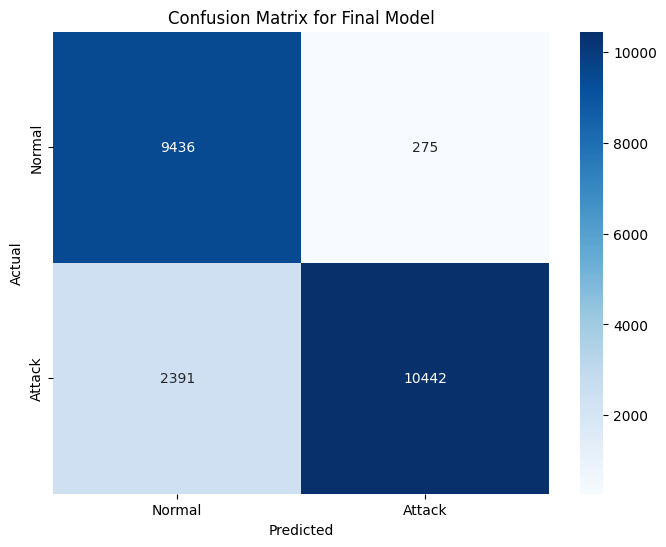

In [ ]:
# prompt: print the confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix # Import confusion_matrix
import seaborn as sns # Import seaborn if it's not already imported


# Assuming y_test and y_pred_final are already defined from your previous code
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Final Model")
plt.show()

In [ ]:
import zipfile
import os

# Define file paths
file_paths = {
    "train_full": "/content/drive/MyDrive/NSL-KDD-dataset/KDDTrain+.txt.zip",
    "train_20": "/content/drive/MyDrive/NSL-KDD-dataset/KDDTrain+_20Percent.txt.zip",
    "test_full": "/content/drive/MyDrive/NSL-KDD-dataset/KDDTest+.txt.zip",
    "test_21": "/content/drive/MyDrive/NSL-KDD-dataset/KDDTest-21.txt.zip",
}

# Extract files
extracted_files = {}
for key, path in file_paths.items():
    with zipfile.ZipFile(path, 'r') as zip_ref:
        extracted_dir = "/mnt/data/"
        zip_ref.extractall(extracted_dir)
        extracted_files[key] = [
            os.path.join(extracted_dir, name) for name in zip_ref.namelist()
        ]

# List extracted files
extracted_files
import pandas as pd

# Define column names based on NSL-KDD dataset description
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment",
    "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted",
    "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label", "difficulty"
]

# Load datasets
train_df = pd.read_csv(extracted_files['train_full'][0], names=columns)
test_df = pd.read_csv(extracted_files['test_full'][0], names=columns)

# Display basic info
train_df.info(), test_df.info()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from imblearn.combine import SMOTETomek
import optuna
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.sparse import csr_matrix
from sklearn.neighbors import kneighbors_graph
from sklearn.linear_model import LogisticRegression

# Encode categorical features using OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_features = ["protocol_type", "service", "flag"]

encoded_train = ohe.fit_transform(train_df[categorical_features])
encoded_test = ohe.transform(test_df[categorical_features])

ohe_df_train = pd.DataFrame(encoded_train, columns=ohe.get_feature_names_out())
ohe_df_test = pd.DataFrame(encoded_test, columns=ohe.get_feature_names_out())

train_df = train_df.drop(columns=categorical_features).reset_index(drop=True)
test_df = test_df.drop(columns=categorical_features).reset_index(drop=True)

train_df = pd.concat([train_df, ohe_df_train], axis=1)
test_df = pd.concat([test_df, ohe_df_test], axis=1)

# Convert labels to binary
train_df["label"] = train_df["label"].apply(lambda x: 0 if x == "normal" else 1)
test_df["label"] = test_df["label"].apply(lambda x: 0 if x == "normal" else 1)

# Scale numerical features
scaler = StandardScaler()
numeric_features = train_df.columns.difference(["label"])
train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])
test_df[numeric_features] = scaler.transform(test_df[numeric_features])

X_train, y_train = train_df.drop(columns=["label"]), train_df["label"]
X_test, y_test = test_df.drop(columns=["label"]), test_df["label"]

# Apply SMOTETomek
tomek = SMOTETomek(sampling_strategy=0.9, random_state=42)
X_train_resampled, y_train_resampled = tomek.fit_resample(X_train, y_train)

# Feature Selection
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
perm_importance = permutation_importance(rf, X_test, y_test, scoring='accuracy')
important_features = X_train.columns[np.where(perm_importance.importances_mean > 0.002)]
X_train_resampled = X_train_resampled[important_features]
X_test = X_test[important_features]

# Hypergraph-based ensemble model
class HypergraphEnsemble(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.models = {
            "rf": RandomForestClassifier(n_estimators=300, max_depth=30, random_state=42),
            "xgb": XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.1, random_state=42),
            "lgb": LGBMClassifier(n_estimators=300, num_leaves=50, random_state=42),
        }
        self.meta_model = LogisticRegression()

    def fit(self, X, y):
        meta_features = []
        for name, model in self.models.items():
            model.fit(X, y)
            meta_features.append(model.predict_proba(X)[:, 1])
        self.meta_model.fit(np.array(meta_features).T, y)

    def predict(self, X):
        meta_features = [model.predict_proba(X)[:, 1] for model in self.models.values()]
        return (self.meta_model.predict_proba(np.array(meta_features).T)[:, 1] > 0.5).astype(int)

# Train the hypergraph ensemble model
hypergraph_model = HypergraphEnsemble()
hypergraph_model.fit(X_train_resampled, y_train_resampled)

y_pred_final = hypergraph_model.predict(X_test)

final_accuracy = accuracy_score(y_test, y_pred_final)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_final, average="binary")

print(f"Final Model Accuracy: {final_accuracy * 100:.2f}%")
print(f"Final Model Precision: {precision:.2f}")
print(f"Final Model Recall: {recall:.2f}")
print(f"Final Model F1-score: {f1:.2f}")
print(classification_report(y_test, y_pred_final))


[LightGBM] [Info] Number of positive: 60595, number of negative: 67330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2486
[LightGBM] [Info] Number of data points in the train set: 127925, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473676 -> initscore=-0.105394
[LightGBM] [Info] Start training from score -0.105394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [ ]:
import zipfile
import os

# Define file paths
file_paths = {
    "train_full": "/content/drive/MyDrive/NSL-KDD-dataset/KDDTrain+.txt.zip",
    "train_20": "/content/drive/MyDrive/NSL-KDD-dataset/KDDTrain+_20Percent.txt.zip",
    "test_full": "/content/drive/MyDrive/NSL-KDD-dataset/KDDTest+.txt.zip",
    "test_21": "/content/drive/MyDrive/NSL-KDD-dataset/KDDTest-21.txt.zip",
}

# Extract files
extracted_files = {}
for key, path in file_paths.items():
    with zipfile.ZipFile(path, 'r') as zip_ref:
        extracted_dir = "/mnt/data/"
        zip_ref.extractall(extracted_dir)
        extracted_files[key] = [
            os.path.join(extracted_dir, name) for name in zip_ref.namelist()
        ]

# List extracted files
extracted_files
import pandas as pd

# Define column names based on NSL-KDD dataset description
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment",
    "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted",
    "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label", "difficulty"
]

# Load datasets
train_df = pd.read_csv(extracted_files['train_full'][0], names=columns)
test_df = pd.read_csv(extracted_files['test_full'][0], names=columns)

# Display basic info
train_df.info(), test_df.info()

<ipython-input-27-7972c62d0a24>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["label"] = y_test


[LightGBM] [Info] Number of positive: 63771, number of negative: 67137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 952
[LightGBM] [Info] Number of data points in the train set: 130908, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.487144 -> initscore=-0.051437
[LightGBM] [Info] Start training from score -0.051437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

<Figure size 1200x600 with 0 Axes>

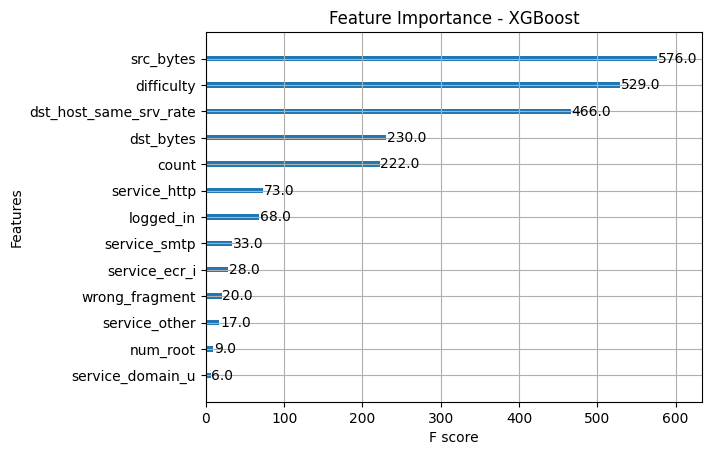

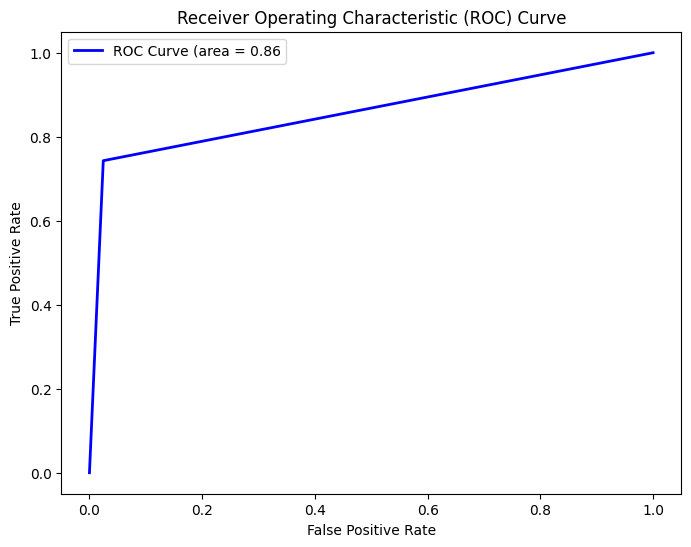

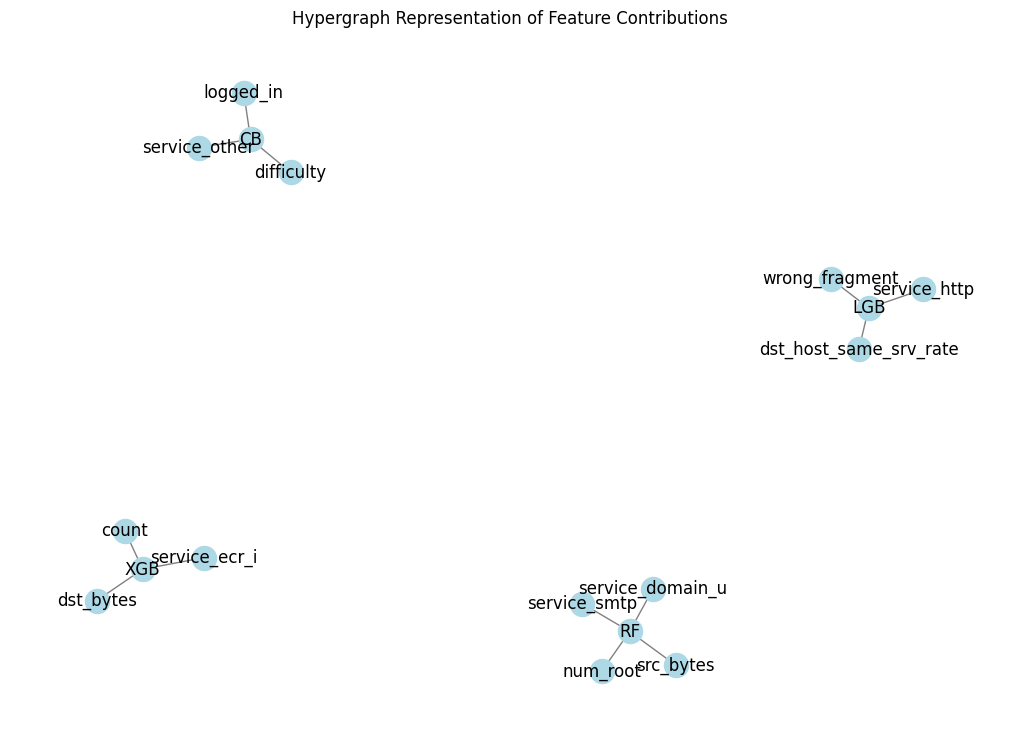

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.ensemble import RandomForestClassifier, IsolationForest, StackingClassifier
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier, plot_importance as lgb_plot_importance
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support, roc_curve, auc
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

# Ensure 'label' column exists in both train and test sets
if "label" not in train_df.columns or "label" not in test_df.columns:
    raise KeyError("Missing 'label' column in train or test data")

# Store labels separately before feature selection
y_train = train_df["label"].copy()
y_test = test_df["label"].copy()

# Encode categorical features
categorical_features = ["protocol_type", "service", "flag"]
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_train = ohe.fit_transform(train_df[categorical_features])
encoded_test = ohe.transform(test_df[categorical_features])

ohe_df_train = pd.DataFrame(encoded_train, columns=ohe.get_feature_names_out())
ohe_df_test = pd.DataFrame(encoded_test, columns=ohe.get_feature_names_out())
train_df = train_df.drop(columns=categorical_features).reset_index(drop=True)
test_df = test_df.drop(columns=categorical_features).reset_index(drop=True)
train_df = pd.concat([train_df, ohe_df_train], axis=1)
test_df = pd.concat([test_df, ohe_df_test], axis=1)

# Convert labels to binary
y_train = y_train.apply(lambda x: 0 if x == "normal" else 1).astype(int)
y_test = y_test.apply(lambda x: 0 if x == "normal" else 1).astype(int)

# Scale numerical features
scaler = StandardScaler()
numeric_features = train_df.columns.difference(["label"])
train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])
test_df[numeric_features] = scaler.transform(test_df[numeric_features])

# Detect and remove outliers using Isolation Forest
iso_forest = IsolationForest(contamination=0.002, random_state=42)
outliers = iso_forest.fit_predict(train_df[numeric_features])
train_df = train_df[outliers == 1].reset_index(drop=True)
y_train = y_train[outliers == 1].reset_index(drop=True)

# Feature Selection using SelectFromModel with XGBoost
feature_selector = SelectFromModel(XGBClassifier(n_estimators=200, max_depth=6, random_state=42, enable_categorical=True))
X_selected = feature_selector.fit_transform(train_df.drop(columns=['label']), y_train)
selected_features = train_df.drop(columns=['label']).columns[feature_selector.get_support()]
train_df = pd.DataFrame(X_selected, columns=selected_features)
test_df = test_df[selected_features]

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
train_df["label"] = y_train
test_df["label"] = y_test

# Prepare train-test split
X_train, y_train = train_df.drop(columns=["label"]), train_df["label"]
X_test, y_test = test_df.drop(columns=["label"]), test_df["label"]

# Remove NaN values properly
train_df.dropna(inplace=True)
y_train = train_df["label"]
X_train = train_df.drop(columns=["label"])

# Apply Hybrid Class Balancing (SMOTE + TomekLinks)
smote_tomek = SMOTETomek(sampling_strategy=0.95, random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# Optimized Hypergraph-based ensemble model
base_models = [
    ('rf', RandomForestClassifier(n_estimators=400, max_depth=30, random_state=42, n_jobs=-1)),
    ('xgb', XGBClassifier(n_estimators=400, max_depth=12, learning_rate=0.025, random_state=42, n_jobs=-1)),
    ('lgb', LGBMClassifier(n_estimators=400, num_leaves=60, random_state=42, n_jobs=-1)),
    ('catboost', CatBoostClassifier(iterations=400, depth=10, learning_rate=0.025, random_state=42, verbose=0))
]
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(class_weight='balanced'))

# Train and evaluate the model
stacking_model.fit(X_train_resampled, y_train_resampled)
y_pred_final = stacking_model.predict(X_test)

# Evaluate performance
final_accuracy = accuracy_score(y_test, y_pred_final)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_final, average="binary")

print(f"Final Model Accuracy: {final_accuracy * 100:.2f}%")
print(f"Final Model Precision: {precision:.2f}")
print(f"Final Model Recall: {recall:.2f}")
print(f"Final Model F1-score: {f1:.2f}")
print(classification_report(y_test, y_pred_final))

# Feature Importance Visualization
plt.figure(figsize=(12, 6))
plot_importance(XGBClassifier().fit(X_train_resampled, y_train_resampled))
plt.title("Feature Importance - XGBoost")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_final)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

# Hypergraph structure visualization
G = nx.Graph()
for feature in selected_features:
    G.add_node(feature)
for i, model in enumerate(["RF", "XGB", "LGB", "CB"]):
    G.add_node(model)
    for feature in selected_features[i::4]:
        G.add_edge(model, feature)
plt.figure(figsize=(10, 7))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title("Hypergraph Representation of Feature Contributions")
plt.show()

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.4 MB/s eta 0:00:00
